<a href="https://colab.research.google.com/github/Cristinamulas/NLP_HW_Fordham_University/blob/master/Book1_train_data_Cris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTES:
- I think I have to train/test split adn then tokenize the data
- Shoud we remove stop words?
# notes 11/28
- need to remove words like 'said, 'like' from the clusters
- create a new col with the cluster labels, so we ca used if we want to do classidication
- review LDA != K-menans
# NEXT
- text summarizer model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/My Drive/NLPFinalProject/'
# !pwd
# !ls
# %cd newsroom
# !ls

/content/drive/.shortcut-targets-by-id/1Jh9kShSLbbNegSGk3J7FQsuKrxpjoWT2/NLPFinalProject


In [3]:
!pip install -e git+git://github.com/clic-lab/newsroom.git#egg=newsroom


Obtaining newsroom from git+git://github.com/clic-lab/newsroom.git#egg=newsroom
  Updating ./src/newsroom clone
  Running command git fetch -q --tags
  Running command git reset --hard -q eed3f2a86d96332395bdd4e4b42f1c51239907f0
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 184kB 16.1MB/s 
  Created wheel for pyrouge: filename=pyrouge-0.1.3-cp36-none-any.whl size=191613 sha256=dcee1fa1aa2f310b6062db75ba3ea0175f2134633e92ef50316b59c6e93978dd
  Stored in directory: /root/.cache/pip/wheels/75/d3/0c/e5b04e15b6b87c42e980de3931d2686e14d36e045058983599
Successfully built pyrouge
  Running setup.py develop for newsroom


In [3]:

from newsroom import jsonl


In [ ]:
# !pwd
# %cd '/content/gdrive/MyDrive/NLPFinalProject/'


ImportError: ignored

In [4]:
with jsonl.open("test.dataset", gzip = True) as train_file:
    train = train_file.read()


In [5]:
train 

[{'archive': 'http://web.archive.org/web/20150928011425id_/http://www.cnbc.com/2015/06/04/we-can-watch-tv-whenever-we-want-and-its-not-thursdays.html',
  'compression': 8.961538461538462,
  'compression_bin': 'low',
  'coverage': 0.4230769230769231,
  'coverage_bin': 'low',
  'date': '20150928011425',
  'density': 0.6538461538461539,
  'density_bin': 'abstractive',
  'summary': 'More consumers are choosing to watch their favorite shows through "TV Everywhere" on-demand options, and they don\'t choose Thursdays.',
  'text': 'Among over-the-top devices, Apple TV saw huge market gains recently, jumping from 5 percent of views before Christmas to 10 percent in the first quarter of 2015. Overall, Apple devices drive 62 percent of all pay-TV video views, according to the Adobe Digital Index data. That was even before HBO Now was released exclusively for Apple devices and AppleTV prices dropped, which could lead to a second buying spree.\n\n"A lot of AppleTVs were under the Christmas tree," s

In [6]:
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import skipgrams

import re
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from nltk.stem import PorterStemmer
stemming = PorterStemmer()
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
df = pd.DataFrame.from_dict(train, orient='columns') # convert the json file into a df


In [8]:
df.head()

url  ...  density_bin
0  http://www.cnbc.com/2015/06/04/we-can-watch-tv...  ...  abstractive
1  http://www.9news.com.au/national/2016/09/22/12...  ...  abstractive
2  https://www.theguardian.com/football/2016/oct/...  ...        mixed
3  http://www.cbc.ca/news/canada/montreal/concord...  ...        mixed
4  http://krugman.blogs.nytimes.com/2012/12/29/on...  ...        mixed

[5 rows x 12 columns]

In [9]:
df.columns

Index(['url', 'archive', 'title', 'date', 'text', 'summary', 'density',
       'coverage', 'compression', 'compression_bin', 'coverage_bin',
       'density_bin'],
      dtype='object')

In [10]:
df = df[['url','title', 'date', 'text', 'summary']] # using a few columns

In [11]:
df.head()

url  ...                                            summary
0  http://www.cnbc.com/2015/06/04/we-can-watch-tv...  ...  More consumers are choosing to watch their fav...
1  http://www.9news.com.au/national/2016/09/22/12...  ...  Factions and policy making have helped Bill Sh...
2  https://www.theguardian.com/football/2016/oct/...  ...  North America becomes stronger favorite to hos...
3  http://www.cbc.ca/news/canada/montreal/concord...  ...  After more than three months in an Iranian pri...
4  http://krugman.blogs.nytimes.com/2012/12/29/on...  ...                       Grand Bargain or Great Scam.

[5 rows x 5 columns]

In [12]:
# Checking for unique values 
len(df['url'].unique())
# so far this df doesnt have duplicates articles

1003

## Data Pre-procesing

- Remove numbers, and stop words and ' using NLTK
- keras tokenizer only remove puntuation


In [29]:

def remove_numbres(st):
  remove_numbres = re.sub('\w*\d\w*', '', st) # remove numbers
  remove_some_punct = re.sub('-', ' ', remove_numbres)
  tokens_without_sw_stem = [stemming.stem(word) for word in remove_some_punct.split() if not word in list(set(stopwords.words('english')))]
  return tokens_without_sw_stem
  


In [30]:
df['try1'] = df['text'].apply(lambda x : remove_numbres(x))


In [ ]:
# df['text_split'] = df['try1'].apply(lambda x: x.split()) # converte into a list of str

In [ ]:
tokenizer = Tokenizer(num_words=20000) # maybe we need to increse this number when we train all the df use ~ 20000 with all df or more
tokens = tokenizer.fit_on_texts(df['try1'])
sequences = tokenizer.texts_to_sequences(df['try1'])


In [ ]:
print(tokenizer.word_counts)
# print(t.document_count)
# print(sorted(t.word_index))
# print(t.word_docs)


OrderedDict([('among', 1), ('top', 1), ('devices', 1), ('appl', 6), ('tv', 2), ('saw', 1), ('huge', 1), ('market', 2), ('gain', 1), ('recently', 1), ('jump', 1), ('percent', 3), ('view', 1), ('christma', 2), ('first', 1), ('quarter', 1), ('overall', 1), ('devic', 3), ('drive', 1), ('pay', 1), ('video', 1), ('views', 1), ('accord', 1), ('adob', 1), ('digit', 1), ('index', 1), ('data', 1), ('that', 1), ('even', 1), ('hbo', 1), ('now', 1), ('releas', 1), ('exclus', 1), ('appletv', 2), ('price', 1), ('dropped', 1), ('could', 1), ('lead', 1), ('second', 1), ('buy', 1), ('spree', 1), ('a', 1), ('lot', 1), ('tree', 1), ('said', 3), ('gaffney', 2), ('amaz', 1), ('posit', 1), ('monet', 1), ('televis', 1), ('content', 3), ('future', 1), ('it', 1), ('remain', 1), ('seen', 1), ('whether', 1), ('take', 1), ('advantag', 1), ('opportunity—mayb', 1), ('see', 1), ("company'", 1), ('wwdc', 1), ("developer'", 1), ('confer', 1), ('next', 2), ('week', 1), ('but', 1), ('chanc', 1), ('domin', 1), ('attract',

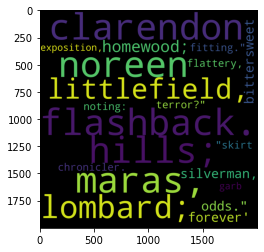

In [ ]:
# from PIL import Image
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud


# wc = WordCloud(background_color="black",width=2000,height=2000, max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(tokenizer.word_index)
# plt.imshow(wc)

In [ ]:
word_sequences = t.sequences_to_texts([df['try1'][0]])
print(word_sequences)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


# Vectorization With TFIDF

In [155]:
## adding customize stop_words to the list
from sklearn.feature_extraction import text 
# my_additional_stop_words =  ['like', 'said','many','year']

# stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)
# stop_words
stop_words = text.ENGLISH_STOP_WORDS

In [156]:
# vectorization with TFIDF
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range = (1,1),stop_words=stop_words)
tfidfv = tfidf.fit_transform(df['text']).toarray()

# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(corpus)
# tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

tf_idf = pd.DataFrame(data = tfidfv, columns=tfidf.get_feature_names())
final_df = tf_idf
final_df.T.tail()

0     1     2     3     4     ...  998   999   1000      1001  1002
youth     0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0  0.000000   0.0
youtube   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0  0.000000   0.0
zealand   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0  0.292761   0.0
zero      0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0  0.000000   0.0
zone      0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0  0.000000   0.0

[5 rows x 1003 columns]

In [113]:
def cluster_texts(num_clusters):
    #perform kmeans clustering for range of clusters
    print('Beginning KMeans Clustering, number of clusters = ', num_clusters, '\n') 
    km = KMeans(n_clusters=num_clusters, max_iter = 100, verbose = 2, n_init = 1).fit(tfidfv)
    
    
    return km

In [114]:
cluster_8 = cluster_texts(8)

Beginning KMeans Clustering, number of clusters =  8 

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 946.8378713824691
start iteration
done sorting
end inner loop
Iteration 1, inertia 944.0620642247584
start iteration
done sorting
end inner loop
Iteration 2, inertia 943.0258850191718
start iteration
done sorting
end inner loop
Iteration 3, inertia 942.2444078758219
start iteration
done sorting
end inner loop
Iteration 4, inertia 941.6104312865541
start iteration
done sorting
end inner loop
Iteration 5, inertia 941.1555782734472
start iteration
done sorting
end inner loop
Iteration 6, inertia 940.8883756718418
start iteration
done sorting
end inner loop
Iteration 7, inertia 940.7075140966
start iteration
done sorting
end inner loop
Iteration 8, inertia 940.554169202065
start iteration
done sorting
end inner loop
Iteration 9, inertia 940.3832539666465
start iteration
done sorting
end inner loop
Iteration 10, inertia 940.27178789587
start iterati

In [157]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tfidf.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

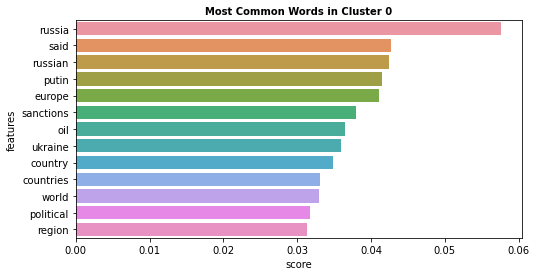

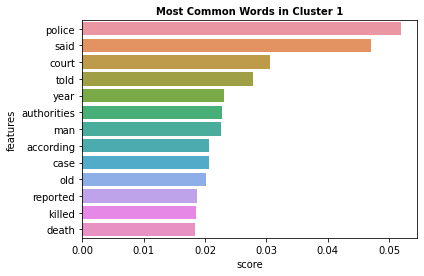

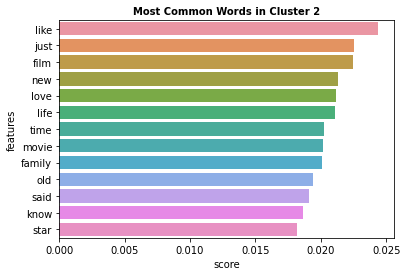

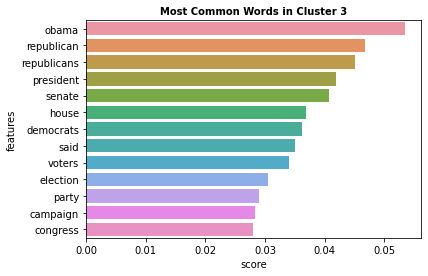

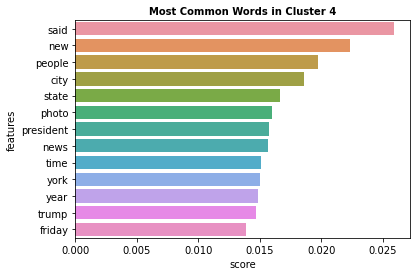

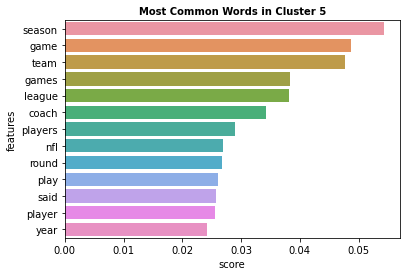

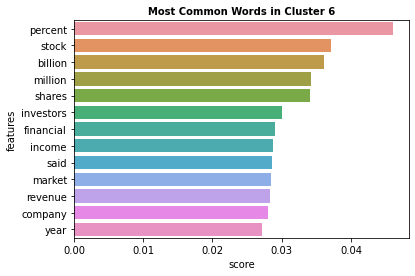

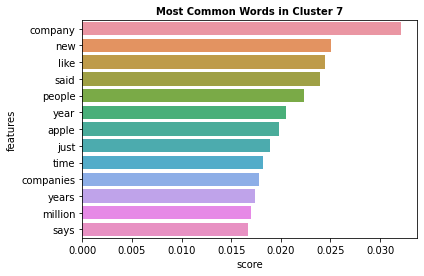

In [158]:
# best_result = 5
# kmeans = kmeans_results.get(best_result)
import seaborn            as sns

final_df_array = final_df.to_numpy()
prediction = cluster_8.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

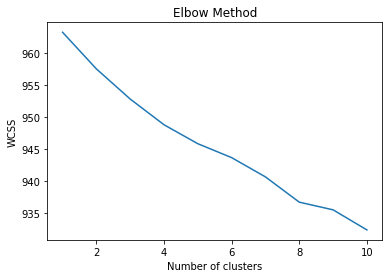

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(tfidfv)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [175]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_words=50, stopwords= stop_words_t, background_color = 'black')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

In [174]:
nltk.download('stopwords')
from nltk.corpus import stopwords # to get rid of StopWords 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud

import nltk # Natural Language ToolKit

# Adding the stopwords
stop_words = stopwords.words('english') 
new_stopwors = ['said', 'like']
stop_words.extend(new_stopwors)
stop_words_t = set(stop_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


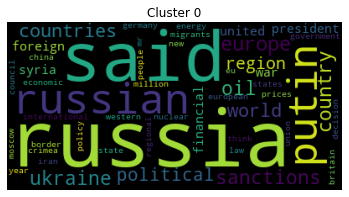

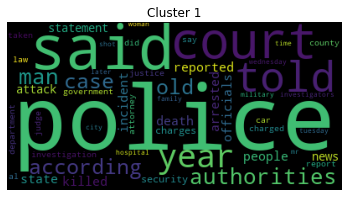

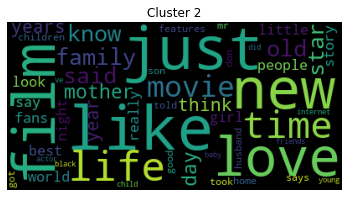

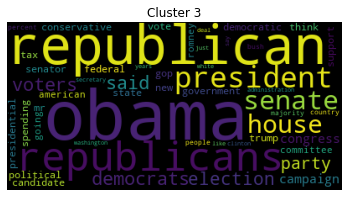

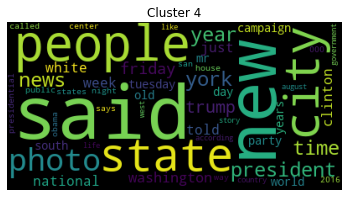

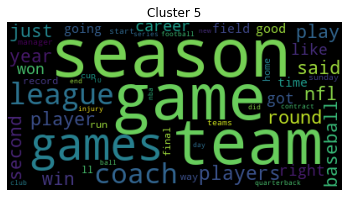

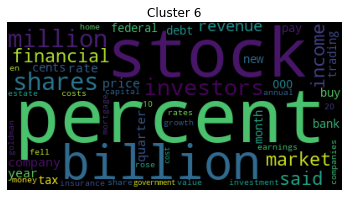

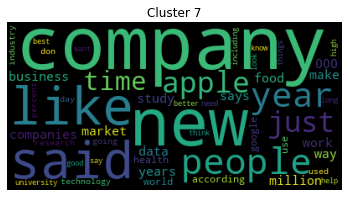

In [176]:
centroids = pd.DataFrame(cluster_8.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [28]:
print("Top terms per cluster:")
order_centroids = cluster_8.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(8):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]: # print the top 10 word in each cluster
    
        print(' %s' % terms[ind])


Top terms per cluster:
Cluster 0:
 like
 new
 apple
 people
 company
 just
 com
 time
 says
 really
Cluster 1:
 trump
 republican
 presidential
 campaign
 clinton
 party
 obama
 president
 candidate
 said
Cluster 2:
 old
 said
 year
 just
 family
 time
 like
 told
 mother
 life
Cluster 3:
 said
 president
 new
 government
 000
 year
 people
 percent
 mr
 years
Cluster 4:
 police
 said
 security
 court
 authorities
 told
 according
 state
 people
 military
Cluster 5:
 season
 game
 team
 coach
 games
 players
 said
 league
 second
 10
Cluster 6:
 scientists
 study
 university
 researchers
 research
 blood
 patients
 new
 human
 disease
Cluster 7:
 company
 investors
 stock
 billion
 shares
 market
 million
 trading
 financial
 said


## LDA topic modeling

In [93]:
# tokezide text data 
def remove_stop_words_lemma(text):
  " it takes an str return a list of tokenize w/o stop words and lemmatization"
  tokenizer = nltk.RegexpTokenizer(r"\w+") # removes putctuation adn numbrers
  tokens = tokenizer.tokenize(text)
  tokens_without_sw_stem = [lemmatizer.lemmatize(word).lower() for word in tokens if not word in list(set(stopwords.words('english')))]
  return tokens_without_sw_stem

In [94]:
df['tokens'] = df['text'].apply(lambda x : remove_stop_words_lemma(x))

In [161]:
# df['tokens'][0]

In [96]:
# remove words than are less or = 3 characnteres
def remove_small_words(lst):
  return [i for i in lst if len(i) > 3]

In [97]:
df['tokens_se'] = df['tokens'].apply(lambda x : remove_small_words(x))

In [98]:
def remove_numbers (text):
  " it removes numbres from the text"
  text_noum = [i for i in text if not i.isdigit()]
  return text_noum


In [99]:
df['tokens_tr'] = df['tokens_se'].apply(lambda x : remove_numbers(x))

In [100]:
# remove words like, said, would, This, that, this, many, year
list_words = ['like', 'said','this','that','many','year','would','told','could']
def remove_words_wo_meaning(text):
  return[ i for i in text if i not in list_words]


In [101]:
df['tokens_four'] = df['tokens_tr'].apply(lambda x :remove_words_wo_meaning(x))

In [162]:
# df['tokens_four'][0]

In [79]:
from gensim import corpora


In [103]:
dictionary = corpora.Dictionary(df['tokens_four'])

In [104]:
corpus = [dictionary.doc2bow(text) for text in df['tokens_four']]


In [82]:
dictionary

In [92]:
# corpus

In [109]:
import gensim
NUM_TOPICS = 5
ldamodel_5 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [107]:
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.006*"clinton" + 0.005*"trump" + 0.004*"people" + 0.003*"photo" + 0.003*"state" + 0.003*"last" + 0.003*"hillary" + 0.003*"time" + 0.003*"presidential" + 0.003*"first"')
(1, '0.006*"million" + 0.004*"people" + 0.003*"time" + 0.003*"also" + 0.003*"company" + 0.003*"percent" + 0.003*"first" + 0.003*"march" + 0.002*"last" + 0.002*"make"')
(2, '0.005*"time" + 0.004*"state" + 0.004*"people" + 0.003*"know" + 0.003*"president" + 0.003*"school" + 0.003*"think" + 0.003*"last" + 0.003*"make" + 0.003*"obama"')
(3, '0.004*"obama" + 0.004*"people" + 0.004*"trump" + 0.003*"president" + 0.003*"time" + 0.003*"also" + 0.003*"group" + 0.003*"last" + 0.003*"court" + 0.002*"first"')
(4, '0.004*"people" + 0.003*"also" + 0.003*"time" + 0.003*"first" + 0.003*"company" + 0.003*"police" + 0.003*"last" + 0.002*"news" + 0.002*"city" + 0.002*"force"')
(5, '0.007*"john" + 0.006*"michael" + 0.005*"joseph" + 0.005*"college" + 0.004*"robert" + 0.004*"thomas" + 0.004*"james" + 0.004*"community" + 0.003*"david" + 

In [90]:
# !pip install pyldavis


     |████████████████████████████████| 1.6MB 18.8MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=2f242261ead87296eba1719832431350b0ea3fa2f173ef73c4cb8910a8d74ab4
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyldavis


In [91]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

- Saliency: a measure of how much the term tells you about the topic.
- Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.
- The size of the bubble measures the importance of the topics, relative to the data.


In [106]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [110]:
lda_display = pyLDAvis.gensim.prepare(ldamodel_5, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)